# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.50744 / CV = ???
- modelo: NN com 3 camadas
- features categoricas: removido
- dados missing: atribuído o valor medio
- feature selection: 25

Versão 1.0.1: LB = 0.52913 / CV = 0.475503
- modelo: NN com 4 camadas
- dados missing: removido colunas com mais de 40% de NA e as demais -999
- features categoricas: label encoder
- feature engineering: usando pacote Boruta

## 1. Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
import re
import random as rd
import os
import codecs
import time
import datetime
import gc
from numba import jit
from collections import Counter
import copy
from typing import Any

seed = 12345
np.random.seed(seed)
rd.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [11]:
# Importa os pacotes de algoritmos
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb 

# Importa os pacotes de algoritmos de redes neurais (Keras)
import keras
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import keras.backend as K
from keras.optimizers import Adam
#from keras_radam import RAdam
from keras import optimizers
from keras.utils import np_utils

# Importa pacotes do sklearn
from sklearn import preprocessing
import sklearn.metrics as mtr
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn import model_selection
from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split as TTS

from keras.callbacks import ReduceLROnPlateau as RLRP
from keras.callbacks import EarlyStopping as ES

## 2. Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))

        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))

        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 133 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 132 colunas


## 3. Feature Engineering

In [5]:
# Removendo todas as colunas com mais de 40% de dados missing
train = train[train.columns[train.isnull().mean() <= 0.4]]
test  = test[test.columns[test.isnull().mean() <= 0.4]]
train.shape, test.shape

((114321, 31), (114393, 30))

In [6]:
# Label encoder nas features categoricas
for c in train.columns[train.dtypes == 'object']:
    train[c] = train[c].factorize()[0]
    
for c in test.columns[test.dtypes == 'object']:
    test[c] = test[c].factorize()[0]

In [7]:
# Preenche os dados missing com -999
train.fillna(-999,inplace=True)
test.fillna(-999,inplace=True)

## 4. Feature Selection

In [8]:
from boruta import BorutaPy

# Separando features preditoras e target
X = train.drop(['ID', 'target'], axis=1)
y = train['target']

X = X.values
y = y.values
y = y.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
rf.fit(X, y)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	23
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	23
Tentative: 	0
Rejected: 	6


In [9]:
X_filtered.shape

(114321, 23)

## 4. Criar e avaliar alguns algoritmos de Machine Learning

In [12]:
# Separando features preditoras e target
train_x = X_filtered.copy()
train_y = train['target']
train_y = to_categorical(train_y)

# Padronizando os dados
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)

train_x.shape, train_y.shape

((114321, 23), (114321, 2))

## 4.1. Algoritmo Deep Neural Network

In [13]:
gc.collect()

72

In [22]:
def get_nn(x_tr,y_tr,x_val,y_val,shape):
    K.clear_session()
    
    inp = Input(shape = (x_tr.shape[1],))

    x = Dense(256, input_dim=x_tr.shape[1], activation='relu')(inp)
    x = Dropout(0.625)(x)    
    x = BatchNormalization()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.625)(x)    
    x = BatchNormalization()(x)
    
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)    
    x = BatchNormalization()(x)
    
    x = Dense(16, activation='relu')(x)
    x = Dropout(.25)(x)
    x = BatchNormalization()(x)
    
    out = Dense(2, activation='softmax')(x)
    model = Model(inp,out)
    
    model.compile(optimizer = optimizers.adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99),
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
     
    es = EarlyStopping(monitor='val_loss', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=20)

    mc = ModelCheckpoint('best_model.h5',
                         monitor='val_loss',
                         mode='min',
                         save_best_only=True, 
                         verbose=1, 
                         save_weights_only=True)

    rl = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.1, 
                           patience=10, 
                           verbose=1, 
                           epsilon=1e-4, 
                           mode='min')

    model.fit(x_tr, y_tr,
              validation_data=[x_val, y_val],
              callbacks=[es,mc,rl],
              epochs=250, 
              batch_size=1024,
              verbose=1,
              #class_weight=class_weight_y,
              shuffle=True)
    
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
             
    logloss = log_loss(y_valid, y_pred, eps=1e-15)

    return model, logloss

In [24]:
%%time

loop = 2
fold = 5

oof_nn = np.zeros([loop, train_y.shape[0], train_y.shape[1]])
models_nn = []
logloss_csv_nn = []

#class_weight_y = class_weight.compute_class_weight('balanced',np.unique(train_y), train_y)

for k in range(loop):
    kfold = KFold(fold, random_state = 42 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(train_y)):
        print("-----------")
        print(f'Loop {k+1}/{loop}' + f' Fold {k_fold+1}/{fold}')
        print("-----------")
        
        tr_x, tr_y = train_x[tr_inds], train_y[tr_inds]
        val_x, val_y = train_x[val_inds], train_y[val_inds]
        
        # Train NN
        nn, logloss_nn = get_nn(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0])
        models_nn.append(nn)
        print("the %d fold Log-Loss (NN) is %f"%((k_fold+1), logloss_nn))
        logloss_csv_nn.append(logloss_nn)
        
        #Predict OOF
        oof_nn[k, val_inds, :] = nn.predict(val_x)
        
    print("PARTIAL: mean Log-Loss (NN) is %f"%np.mean(logloss_csv_nn))        

-----------
Loop 1/2 Fold 1/5
-----------
Train on 91456 samples, validate on 22865 samples
Epoch 1/250
91456/91456 [==============================] - 8s 85us/step - loss: 0.5367 - categorical_accuracy: 0.7554 - val_loss: 0.7020 - val_categorical_accuracy: 0.7618

Epoch 00001: val_loss improved from inf to 0.70205, saving model to best_model.h5
Epoch 2/250
91456/91456 [==============================] - 2s 22us/step - loss: 0.5218 - categorical_accuracy: 0.7597 - val_loss: 0.6152 - val_categorical_accuracy: 0.7618

Epoch 00002: val_loss improved from 0.70205 to 0.61520, saving model to best_model.h5
Epoch 3/250
91456/91456 [==============================] - 2s 21us/step - loss: 0.5111 - categorical_accuracy: 0.7598 - val_loss: 0.5293 - val_categorical_accuracy: 0.7618

Epoch 00003: val_loss improved from 0.61520 to 0.52927, saving model to best_model.h5
Epoch 4/250
91456/91456 [==============================] - 2s 21us/step - loss: 0.5050 - categorical_accuracy: 0.7607 - val_loss: 0.564

91456/91456 [==============================] - 2s 17us/step - loss: 0.4897 - categorical_accuracy: 0.7686 - val_loss: 0.4774 - val_categorical_accuracy: 0.7748

Epoch 00034: val_loss did not improve from 0.47525
Epoch 35/250
91456/91456 [==============================] - 2s 18us/step - loss: 0.4901 - categorical_accuracy: 0.7701 - val_loss: 0.4794 - val_categorical_accuracy: 0.7813

Epoch 00035: val_loss did not improve from 0.47525
Epoch 36/250
91456/91456 [==============================] - 2s 18us/step - loss: 0.4925 - categorical_accuracy: 0.7685 - val_loss: 0.4872 - val_categorical_accuracy: 0.7717

Epoch 00036: val_loss did not improve from 0.47525
Epoch 37/250
91456/91456 [==============================] - 2s 17us/step - loss: 0.4901 - categorical_accuracy: 0.7706 - val_loss: 0.4771 - val_categorical_accuracy: 0.7779

Epoch 00037: val_loss did not improve from 0.47525
Epoch 38/250
91456/91456 [==============================] - 2s 17us/step - loss: 0.4900 - categorical_accuracy: 0


Epoch 00068: val_loss did not improve from 0.46878
Epoch 69/250
91456/91456 [==============================] - 1s 16us/step - loss: 0.4795 - categorical_accuracy: 0.7766 - val_loss: 0.4708 - val_categorical_accuracy: 0.7804

Epoch 00069: val_loss did not improve from 0.46878
Epoch 70/250
91456/91456 [==============================] - 1s 16us/step - loss: 0.4811 - categorical_accuracy: 0.7762 - val_loss: 0.4734 - val_categorical_accuracy: 0.7774

Epoch 00070: val_loss did not improve from 0.46878
Epoch 71/250
91456/91456 [==============================] - 1s 15us/step - loss: 0.4797 - categorical_accuracy: 0.7753 - val_loss: 0.4735 - val_categorical_accuracy: 0.7784

Epoch 00071: val_loss did not improve from 0.46878
Epoch 72/250
91456/91456 [==============================] - 1s 15us/step - loss: 0.4803 - categorical_accuracy: 0.7770 - val_loss: 0.4701 - val_categorical_accuracy: 0.7817

Epoch 00072: val_loss did not improve from 0.46878
Epoch 73/250
91456/91456 [======================

91457/91457 [==============================] - 1s 14us/step - loss: 0.4929 - categorical_accuracy: 0.7681 - val_loss: 0.5213 - val_categorical_accuracy: 0.7579

Epoch 00015: val_loss did not improve from 0.49131
Epoch 16/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4929 - categorical_accuracy: 0.7671 - val_loss: 0.4951 - val_categorical_accuracy: 0.7724

Epoch 00016: val_loss did not improve from 0.49131
Epoch 17/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4929 - categorical_accuracy: 0.7671 - val_loss: 0.4995 - val_categorical_accuracy: 0.7672

Epoch 00017: val_loss did not improve from 0.49131
Epoch 18/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4943 - categorical_accuracy: 0.7679 - val_loss: 0.5024 - val_categorical_accuracy: 0.7657

Epoch 00018: val_loss did not improve from 0.49131
Epoch 19/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4935 - categorical_accuracy: 0

91457/91457 [==============================] - 1s 12us/step - loss: 0.4805 - categorical_accuracy: 0.7764 - val_loss: 0.5019 - val_categorical_accuracy: 0.7727

Epoch 00050: val_loss did not improve from 0.48848
Epoch 51/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4791 - categorical_accuracy: 0.7765 - val_loss: 0.5064 - val_categorical_accuracy: 0.7718

Epoch 00051: val_loss did not improve from 0.48848
Epoch 52/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4808 - categorical_accuracy: 0.7757 - val_loss: 0.5099 - val_categorical_accuracy: 0.7729

Epoch 00052: val_loss did not improve from 0.48848
Epoch 53/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4801 - categorical_accuracy: 0.7758 - val_loss: 0.5129 - val_categorical_accuracy: 0.7735

Epoch 00053: val_loss did not improve from 0.48848
Epoch 54/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4795 - categorical_accuracy: 0

91457/91457 [==============================] - 1s 13us/step - loss: 0.4922 - categorical_accuracy: 0.7688 - val_loss: 0.4823 - val_categorical_accuracy: 0.7747

Epoch 00029: val_loss did not improve from 0.48108
Epoch 30/250
91457/91457 [==============================] - 1s 13us/step - loss: 0.4889 - categorical_accuracy: 0.7704 - val_loss: 0.4780 - val_categorical_accuracy: 0.7773

Epoch 00030: val_loss improved from 0.48108 to 0.47796, saving model to best_model.h5
Epoch 31/250
91457/91457 [==============================] - 1s 13us/step - loss: 0.4890 - categorical_accuracy: 0.7698 - val_loss: 0.4872 - val_categorical_accuracy: 0.7710

Epoch 00031: val_loss did not improve from 0.47796
Epoch 32/250
91457/91457 [==============================] - 1s 13us/step - loss: 0.4895 - categorical_accuracy: 0.7713 - val_loss: 0.4804 - val_categorical_accuracy: 0.7723

Epoch 00032: val_loss did not improve from 0.47796
Epoch 33/250
91457/91457 [==============================] - 1s 13us/step - los

91457/91457 [==============================] - 1s 13us/step - loss: 0.4779 - categorical_accuracy: 0.7773 - val_loss: 0.4772 - val_categorical_accuracy: 0.7766

Epoch 00064: val_loss did not improve from 0.47560
Epoch 65/250
91457/91457 [==============================] - 1s 13us/step - loss: 0.4786 - categorical_accuracy: 0.7773 - val_loss: 0.4829 - val_categorical_accuracy: 0.7716

Epoch 00065: val_loss did not improve from 0.47560
Epoch 66/250
91457/91457 [==============================] - 1s 13us/step - loss: 0.4783 - categorical_accuracy: 0.7762 - val_loss: 0.4765 - val_categorical_accuracy: 0.7765

Epoch 00066: val_loss did not improve from 0.47560
Epoch 67/250
91457/91457 [==============================] - 1s 13us/step - loss: 0.4782 - categorical_accuracy: 0.7770 - val_loss: 0.4759 - val_categorical_accuracy: 0.7763

Epoch 00067: val_loss did not improve from 0.47560
Epoch 68/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4789 - categorical_accuracy: 0

91457/91457 [==============================] - 1s 13us/step - loss: 0.4773 - categorical_accuracy: 0.7774 - val_loss: 0.4755 - val_categorical_accuracy: 0.7762

Epoch 00099: val_loss did not improve from 0.47534
Epoch 100/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4777 - categorical_accuracy: 0.7773 - val_loss: 0.4756 - val_categorical_accuracy: 0.7762

Epoch 00100: val_loss did not improve from 0.47534
Epoch 101/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4773 - categorical_accuracy: 0.7771 - val_loss: 0.4757 - val_categorical_accuracy: 0.7762

Epoch 00101: val_loss did not improve from 0.47534
Epoch 102/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4770 - categorical_accuracy: 0.7772 - val_loss: 0.4759 - val_categorical_accuracy: 0.7762

Epoch 00102: val_loss did not improve from 0.47534
Epoch 103/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4774 - categorical_accurac

91457/91457 [==============================] - 1s 14us/step - loss: 0.4907 - categorical_accuracy: 0.7696 - val_loss: 0.5011 - val_categorical_accuracy: 0.7669

Epoch 00030: val_loss did not improve from 0.48007
Epoch 31/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4905 - categorical_accuracy: 0.7698 - val_loss: 0.4840 - val_categorical_accuracy: 0.7662

Epoch 00031: val_loss did not improve from 0.48007
Epoch 32/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4910 - categorical_accuracy: 0.7703 - val_loss: 0.4812 - val_categorical_accuracy: 0.7717

Epoch 00032: val_loss did not improve from 0.48007
Epoch 33/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4900 - categorical_accuracy: 0.7695 - val_loss: 0.4893 - val_categorical_accuracy: 0.7646

Epoch 00033: val_loss did not improve from 0.48007
Epoch 34/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4897 - categorical_accuracy: 0

91457/91457 [==============================] - 1s 14us/step - loss: 0.4796 - categorical_accuracy: 0.7762 - val_loss: 0.4755 - val_categorical_accuracy: 0.7762

Epoch 00065: val_loss did not improve from 0.47363
Epoch 66/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4796 - categorical_accuracy: 0.7757 - val_loss: 0.4743 - val_categorical_accuracy: 0.7794

Epoch 00066: val_loss did not improve from 0.47363
Epoch 67/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4795 - categorical_accuracy: 0.7763 - val_loss: 0.4744 - val_categorical_accuracy: 0.7771

Epoch 00067: val_loss did not improve from 0.47363
Epoch 68/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4789 - categorical_accuracy: 0.7768 - val_loss: 0.4758 - val_categorical_accuracy: 0.7748

Epoch 00068: val_loss did not improve from 0.47363
Epoch 69/250
91457/91457 [==============================] - 1s 14us/step - loss: 0.4790 - categorical_accuracy: 0

91457/91457 [==============================] - 2s 17us/step - loss: 0.4757 - categorical_accuracy: 0.7775 - val_loss: 0.4726 - val_categorical_accuracy: 0.7776

Epoch 00100: val_loss did not improve from 0.47107
Epoch 101/250
91457/91457 [==============================] - 2s 17us/step - loss: 0.4758 - categorical_accuracy: 0.7780 - val_loss: 0.4726 - val_categorical_accuracy: 0.7775

Epoch 00101: val_loss did not improve from 0.47107
Epoch 102/250
91457/91457 [==============================] - 2s 17us/step - loss: 0.4764 - categorical_accuracy: 0.7782 - val_loss: 0.4727 - val_categorical_accuracy: 0.7771

Epoch 00102: val_loss did not improve from 0.47107
Epoch 103/250
91457/91457 [==============================] - 2s 17us/step - loss: 0.4766 - categorical_accuracy: 0.7781 - val_loss: 0.4724 - val_categorical_accuracy: 0.7781

Epoch 00103: val_loss did not improve from 0.47107
Epoch 104/250
91457/91457 [==============================] - 2s 17us/step - loss: 0.4766 - categorical_accurac


Epoch 00025: val_loss did not improve from 0.48108
Epoch 26/250
91457/91457 [==============================] - 2s 17us/step - loss: 0.4915 - categorical_accuracy: 0.7687 - val_loss: 0.4867 - val_categorical_accuracy: 0.7684

Epoch 00026: val_loss did not improve from 0.48108
Epoch 27/250
91457/91457 [==============================] - 2s 17us/step - loss: 0.4914 - categorical_accuracy: 0.7686 - val_loss: 0.4803 - val_categorical_accuracy: 0.7765

Epoch 00027: val_loss improved from 0.48108 to 0.48034, saving model to best_model.h5
Epoch 28/250
91457/91457 [==============================] - 2s 17us/step - loss: 0.4914 - categorical_accuracy: 0.7699 - val_loss: 0.4969 - val_categorical_accuracy: 0.7556

Epoch 00028: val_loss did not improve from 0.48034
Epoch 29/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.4893 - categorical_accuracy: 0.7695 - val_loss: 0.4958 - val_categorical_accuracy: 0.7630

Epoch 00029: val_loss did not improve from 0.48034
Epoch 30/250


91457/91457 [==============================] - 1s 16us/step - loss: 0.4789 - categorical_accuracy: 0.7779 - val_loss: 0.4792 - val_categorical_accuracy: 0.7746

Epoch 00061: val_loss did not improve from 0.47625
Epoch 62/250
91457/91457 [==============================] - 2s 17us/step - loss: 0.4793 - categorical_accuracy: 0.7774 - val_loss: 0.4774 - val_categorical_accuracy: 0.7762

Epoch 00062: val_loss did not improve from 0.47625
Epoch 63/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.4788 - categorical_accuracy: 0.7783 - val_loss: 0.4754 - val_categorical_accuracy: 0.7781

Epoch 00063: val_loss improved from 0.47625 to 0.47544, saving model to best_model.h5
Epoch 64/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.4788 - categorical_accuracy: 0.7773 - val_loss: 0.4772 - val_categorical_accuracy: 0.7773

Epoch 00064: val_loss did not improve from 0.47544
Epoch 65/250
91457/91457 [==============================] - 1s 16us/step - los

91456/91456 [==============================] - 1s 14us/step - loss: 0.4956 - categorical_accuracy: 0.7646 - val_loss: 0.5179 - val_categorical_accuracy: 0.7637

Epoch 00012: val_loss did not improve from 0.50569
Epoch 13/250
91456/91456 [==============================] - 1s 14us/step - loss: 0.4963 - categorical_accuracy: 0.7652 - val_loss: 0.4914 - val_categorical_accuracy: 0.7690

Epoch 00013: val_loss improved from 0.50569 to 0.49144, saving model to best_model.h5
Epoch 14/250
91456/91456 [==============================] - 1s 14us/step - loss: 0.4943 - categorical_accuracy: 0.7647 - val_loss: 0.5537 - val_categorical_accuracy: 0.7614

Epoch 00014: val_loss did not improve from 0.49144
Epoch 15/250
91456/91456 [==============================] - 1s 15us/step - loss: 0.4947 - categorical_accuracy: 0.7654 - val_loss: 0.4924 - val_categorical_accuracy: 0.7726

Epoch 00015: val_loss did not improve from 0.49144
Epoch 16/250
91456/91456 [==============================] - 1s 14us/step - los


Epoch 00047: val_loss did not improve from 0.48308
Epoch 48/250
91456/91456 [==============================] - 1s 14us/step - loss: 0.4863 - categorical_accuracy: 0.7713 - val_loss: 0.4878 - val_categorical_accuracy: 0.7760

Epoch 00048: val_loss did not improve from 0.48308
Epoch 49/250
91456/91456 [==============================] - 1s 14us/step - loss: 0.4854 - categorical_accuracy: 0.7720 - val_loss: 0.4918 - val_categorical_accuracy: 0.7700

Epoch 00049: val_loss did not improve from 0.48308
Epoch 50/250
91456/91456 [==============================] - 1s 14us/step - loss: 0.4866 - categorical_accuracy: 0.7712 - val_loss: 0.4918 - val_categorical_accuracy: 0.7796

Epoch 00050: val_loss did not improve from 0.48308

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 51/250
91456/91456 [==============================] - 1s 15us/step - loss: 0.4809 - categorical_accuracy: 0.7748 - val_loss: 0.4821 - val_categorical_accuracy: 0.7749

Epoch 00051: val_lo


Epoch 00082: val_loss did not improve from 0.47883
Epoch 83/250
91456/91456 [==============================] - 1s 15us/step - loss: 0.4766 - categorical_accuracy: 0.7769 - val_loss: 0.4820 - val_categorical_accuracy: 0.7728

Epoch 00083: val_loss did not improve from 0.47883
Epoch 84/250
91456/91456 [==============================] - 1s 15us/step - loss: 0.4763 - categorical_accuracy: 0.7778 - val_loss: 0.4834 - val_categorical_accuracy: 0.7712

Epoch 00084: val_loss did not improve from 0.47883

Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 85/250
91456/91456 [==============================] - 1s 15us/step - loss: 0.4752 - categorical_accuracy: 0.7784 - val_loss: 0.4804 - val_categorical_accuracy: 0.7751

Epoch 00085: val_loss did not improve from 0.47883
Epoch 86/250
91456/91456 [==============================] - 1s 15us/step - loss: 0.4759 - categorical_accuracy: 0.7772 - val_loss: 0.4798 - val_categorical_accuracy: 0.7762

Epoch 00086: val_l


Epoch 00018: val_loss did not improve from 0.47672
Epoch 19/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4941 - categorical_accuracy: 0.7675 - val_loss: 0.4808 - val_categorical_accuracy: 0.7697

Epoch 00019: val_loss did not improve from 0.47672
Epoch 20/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4931 - categorical_accuracy: 0.7674 - val_loss: 0.4785 - val_categorical_accuracy: 0.7808

Epoch 00020: val_loss did not improve from 0.47672
Epoch 21/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4925 - categorical_accuracy: 0.7670 - val_loss: 0.4975 - val_categorical_accuracy: 0.7778

Epoch 00021: val_loss did not improve from 0.47672
Epoch 22/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4926 - categorical_accuracy: 0.7685 - val_loss: 0.4872 - val_categorical_accuracy: 0.7654

Epoch 00022: val_loss did not improve from 0.47672
Epoch 23/250
91457/91457 [======================


Epoch 00053: val_loss did not improve from 0.47128
Epoch 54/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.4799 - categorical_accuracy: 0.7767 - val_loss: 0.4744 - val_categorical_accuracy: 0.7780

Epoch 00054: val_loss did not improve from 0.47128
Epoch 55/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4802 - categorical_accuracy: 0.7766 - val_loss: 0.4719 - val_categorical_accuracy: 0.7805

Epoch 00055: val_loss did not improve from 0.47128
Epoch 56/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.4803 - categorical_accuracy: 0.7760 - val_loss: 0.4734 - val_categorical_accuracy: 0.7790

Epoch 00056: val_loss did not improve from 0.47128
Epoch 57/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4802 - categorical_accuracy: 0.7764 - val_loss: 0.4738 - val_categorical_accuracy: 0.7811

Epoch 00057: val_loss did not improve from 0.47128
Epoch 58/250
91457/91457 [======================

the 2 fold Log-Loss (NN) is 0.470616
-----------
Loop 2/2 Fold 3/5
-----------
Train on 91457 samples, validate on 22864 samples
Epoch 1/250
91457/91457 [==============================] - 3s 32us/step - loss: 0.5407 - categorical_accuracy: 0.7579 - val_loss: 0.6812 - val_categorical_accuracy: 0.7594

Epoch 00001: val_loss improved from inf to 0.68124, saving model to best_model.h5
Epoch 2/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.5201 - categorical_accuracy: 0.7617 - val_loss: 0.5840 - val_categorical_accuracy: 0.7594

Epoch 00002: val_loss improved from 0.68124 to 0.58396, saving model to best_model.h5
Epoch 3/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.5111 - categorical_accuracy: 0.7613 - val_loss: 0.6101 - val_categorical_accuracy: 0.7594

Epoch 00003: val_loss did not improve from 0.58396
Epoch 4/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.5060 - categorical_accuracy: 0.7610 - val_loss: 0.5


Epoch 00034: val_loss improved from 0.47995 to 0.47813, saving model to best_model.h5
Epoch 35/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.4896 - categorical_accuracy: 0.7716 - val_loss: 0.4999 - val_categorical_accuracy: 0.7594

Epoch 00035: val_loss did not improve from 0.47813
Epoch 36/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.4888 - categorical_accuracy: 0.7699 - val_loss: 0.4822 - val_categorical_accuracy: 0.7654

Epoch 00036: val_loss did not improve from 0.47813
Epoch 37/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.4891 - categorical_accuracy: 0.7691 - val_loss: 0.4852 - val_categorical_accuracy: 0.7703

Epoch 00037: val_loss did not improve from 0.47813
Epoch 38/250
91457/91457 [==============================] - 1s 16us/step - loss: 0.4882 - categorical_accuracy: 0.7693 - val_loss: 0.4803 - val_categorical_accuracy: 0.7731

Epoch 00038: val_loss did not improve from 0.47813
Epoch 39/250


91457/91457 [==============================] - 1s 15us/step - loss: 0.4793 - categorical_accuracy: 0.7749 - val_loss: 0.4773 - val_categorical_accuracy: 0.7757

Epoch 00070: val_loss did not improve from 0.47710
Epoch 71/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4791 - categorical_accuracy: 0.7746 - val_loss: 0.4778 - val_categorical_accuracy: 0.7744

Epoch 00071: val_loss did not improve from 0.47710
Epoch 72/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4794 - categorical_accuracy: 0.7752 - val_loss: 0.4779 - val_categorical_accuracy: 0.7746

Epoch 00072: val_loss did not improve from 0.47710
Epoch 73/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4794 - categorical_accuracy: 0.7746 - val_loss: 0.4777 - val_categorical_accuracy: 0.7750

Epoch 00073: val_loss did not improve from 0.47710
Epoch 74/250
91457/91457 [==============================] - 1s 15us/step - loss: 0.4799 - categorical_accuracy: 0


Epoch 00014: val_loss did not improve from 0.47949
Epoch 15/250
91457/91457 [==============================] - 1s 13us/step - loss: 0.4947 - categorical_accuracy: 0.7666 - val_loss: 0.5093 - val_categorical_accuracy: 0.7624

Epoch 00015: val_loss did not improve from 0.47949
Epoch 16/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4945 - categorical_accuracy: 0.7669 - val_loss: 0.5213 - val_categorical_accuracy: 0.7673

Epoch 00016: val_loss did not improve from 0.47949
Epoch 17/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4944 - categorical_accuracy: 0.7672 - val_loss: 0.4957 - val_categorical_accuracy: 0.7718

Epoch 00017: val_loss did not improve from 0.47949
Epoch 18/250
91457/91457 [==============================] - 1s 13us/step - loss: 0.4923 - categorical_accuracy: 0.7687 - val_loss: 0.4868 - val_categorical_accuracy: 0.7705

Epoch 00018: val_loss did not improve from 0.47949
Epoch 19/250
91457/91457 [======================


Epoch 00049: val_loss did not improve from 0.47330
Epoch 50/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4811 - categorical_accuracy: 0.7768 - val_loss: 0.4748 - val_categorical_accuracy: 0.7772

Epoch 00050: val_loss did not improve from 0.47330
Epoch 51/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4813 - categorical_accuracy: 0.7765 - val_loss: 0.4747 - val_categorical_accuracy: 0.7768

Epoch 00051: val_loss did not improve from 0.47330
Epoch 52/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4812 - categorical_accuracy: 0.7764 - val_loss: 0.4756 - val_categorical_accuracy: 0.7764

Epoch 00052: val_loss did not improve from 0.47330
Epoch 53/250
91457/91457 [==============================] - 1s 13us/step - loss: 0.4806 - categorical_accuracy: 0.7766 - val_loss: 0.4760 - val_categorical_accuracy: 0.7766

Epoch 00053: val_loss did not improve from 0.47330
Epoch 54/250
91457/91457 [======================

91457/91457 [==============================] - 1s 13us/step - loss: 0.4951 - categorical_accuracy: 0.7664 - val_loss: 0.4890 - val_categorical_accuracy: 0.7722

Epoch 00016: val_loss improved from 0.49270 to 0.48899, saving model to best_model.h5
Epoch 17/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4927 - categorical_accuracy: 0.7672 - val_loss: 0.4875 - val_categorical_accuracy: 0.7719

Epoch 00017: val_loss improved from 0.48899 to 0.48752, saving model to best_model.h5
Epoch 18/250
91457/91457 [==============================] - 1s 12us/step - loss: 0.4916 - categorical_accuracy: 0.7683 - val_loss: 0.4953 - val_categorical_accuracy: 0.7574

Epoch 00018: val_loss did not improve from 0.48752
Epoch 19/250
91457/91457 [==============================] - 1s 11us/step - loss: 0.4902 - categorical_accuracy: 0.7694 - val_loss: 0.4957 - val_categorical_accuracy: 0.7649

Epoch 00019: val_loss did not improve from 0.48752
Epoch 20/250
91457/91457 [=================

91457/91457 [==============================] - 1s 11us/step - loss: 0.4855 - categorical_accuracy: 0.7739 - val_loss: 0.4864 - val_categorical_accuracy: 0.7748

Epoch 00051: val_loss did not improve from 0.47946
Epoch 52/250
91457/91457 [==============================] - 1s 9us/step - loss: 0.4850 - categorical_accuracy: 0.7731 - val_loss: 0.4847 - val_categorical_accuracy: 0.7678

Epoch 00052: val_loss did not improve from 0.47946
Epoch 53/250
91457/91457 [==============================] - 1s 9us/step - loss: 0.4855 - categorical_accuracy: 0.7720 - val_loss: 0.4830 - val_categorical_accuracy: 0.7749

Epoch 00053: val_loss did not improve from 0.47946

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 54/250
91457/91457 [==============================] - 1s 9us/step - loss: 0.4812 - categorical_accuracy: 0.7744 - val_loss: 0.4785 - val_categorical_accuracy: 0.7762

Epoch 00054: val_loss improved from 0.47946 to 0.47851, saving model to best_model.h5
E

91457/91457 [==============================] - 1s 9us/step - loss: 0.4754 - categorical_accuracy: 0.7784 - val_loss: 0.4780 - val_categorical_accuracy: 0.7742

Epoch 00086: val_loss did not improve from 0.47697
Epoch 87/250
91457/91457 [==============================] - 1s 9us/step - loss: 0.4765 - categorical_accuracy: 0.7776 - val_loss: 0.4785 - val_categorical_accuracy: 0.7734

Epoch 00087: val_loss did not improve from 0.47697
Epoch 88/250
91457/91457 [==============================] - 1s 9us/step - loss: 0.4764 - categorical_accuracy: 0.7776 - val_loss: 0.4783 - val_categorical_accuracy: 0.7738

Epoch 00088: val_loss did not improve from 0.47697
Epoch 89/250
91457/91457 [==============================] - 1s 9us/step - loss: 0.4752 - categorical_accuracy: 0.7782 - val_loss: 0.4780 - val_categorical_accuracy: 0.7743

Epoch 00089: val_loss did not improve from 0.47697
Epoch 90/250
91457/91457 [==============================] - 1s 9us/step - loss: 0.4758 - categorical_accuracy: 0.7780

## Resultado

In [25]:
loss_oof_nn = []

for k in range(loop):
    loss_oof_nn.append(log_loss(train_y, oof_nn[k,...], eps=1e-15))

In [26]:
print("mean log-loss (NN) is %f"%np.mean(logloss_csv_nn))
print("mean OOF log-loss (NN) is %f"%np.mean(loss_oof_nn))

mean log-loss (NN) is 0.475503
mean OOF log-loss (NN) is 0.475503


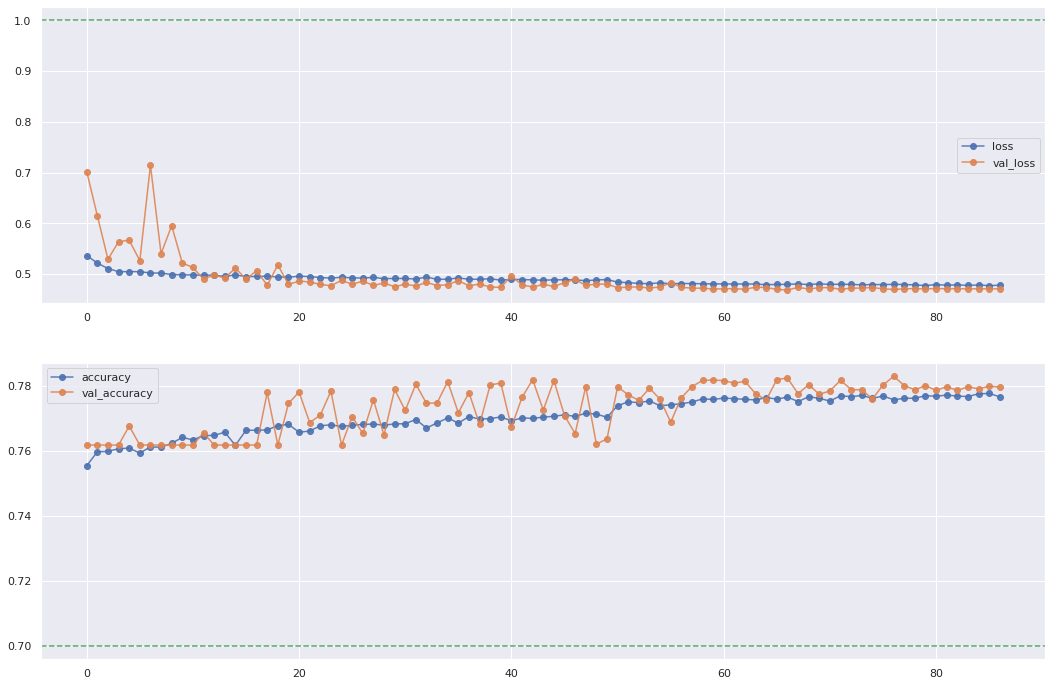

In [29]:
plt.figure(figsize=(18, 12))
plt.subplot(2, 1, 1)
plt.plot(models_nn[0].history.history["loss"], "o-", alpha=.9, label="loss")
plt.plot(models_nn[0].history.history["val_loss"], "o-", alpha=.9, label="val_loss")
plt.axhline(1, linestyle="--", c="C2")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(models_nn[0].history.history["categorical_accuracy"], "o-", alpha=.9, label="accuracy")
plt.plot(models_nn[0].history.history["val_categorical_accuracy"], "o-", alpha=.9, label="val_accuracy")
plt.axhline(.7, linestyle="--", c="C2")
plt.legend()
plt.show()

## Submissions

In [72]:
# Preparando os dados de teste
new_test = test.drop(['ID'], axis=1).values
test_filtered = feat_selector.transform(new_test)
test_filtered = scaler.fit_transform(test_filtered)
test_filtered.shape

(114393, 23)

In [73]:
# Funcao para realizar as previsoes baseado em todos os modelos do Kfold
def predict(x_te, models_nn):
    
    model_num_nn = len(models_nn)

    for k,m in enumerate(models_nn):
        if k==0:
            y_pred_nn = predict_proba(m, x_te, batch_size=1024, verbose=1)
        else:
            y_pred_nn += predict_proba(m, x_te, batch_size=1024, verbose=1)
            
    y_pred_nn = y_pred_nn / model_num_nn
    
    return y_pred_nn

In [74]:
test_pred = predict(test_filtered, models_nn)
test_pred.shape

114393/114393 [==============================] - 0s 2us/step


(114393, 2)

In [63]:
def predict_proba(model, x, batch_size=32, verbose=0):
    preds = model.predict(x, batch_size, verbose)
    if preds.min() < 0. or preds.max() > 1.:
        warnings.warn('Network returning invalid probability values. '
                      'The last layer might not normalize predictions '
                      'into probabilities '
                      '(like softmax or sigmoid would).')
    return preds

In [75]:
test_pred[:,1]

array([0.7225215 , 0.8121257 , 0.66001093, ..., 0.7577859 , 0.6339866 ,
       0.55162346], dtype=float32)

### Submissions NN

In [76]:
submission = pd.read_csv('../dataset/sample_submission.csv')
submission['PredictedProb'] = test_pred[:,1]
print(submission.shape)
submission.head()

(114393, 2)


,ID,PredictedProb
0,0,0.722521
1,1,0.812126
2,2,0.660011
3,7,0.748874
4,10,0.791231


In [80]:
submission.to_csv('../submission/submission_nn_v1.0.1.csv', index=False)

In [77]:
submission['PredictedProb'].value_counts(normalize=True)

0.617608    0.000026
0.869949    0.000026
0.867662    0.000026
0.823046    0.000026
0.779732    0.000026
              ...   
0.916275    0.000009
0.666276    0.000009
0.916277    0.000009
0.916277    0.000009
0.750001    0.000009
Name: PredictedProb, Length: 113081, dtype: float64

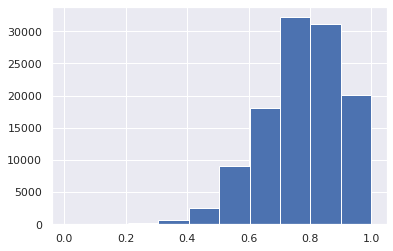

In [78]:
plt.hist(submission.PredictedProb)
plt.show()